In [1]:
import os
import shutil

import numpy as np

import torch
import torch.nn as nn

import minari

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from trl import GRPOConfig, GRPOTrainer

/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-06-23 07:36:43,526] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


INFO 06-23 07:36:44 __init__.py:183] Automatically detected platform cuda.


2025-06-23 07:36:44,672	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Model

In [2]:
from rlft4rl.policies.grpo_mlp_policy import create_mlp_model, load_mlp_model

/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/lib/python3.12/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/lib/python3.12/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/mnt/data_2/abenechehab/micromamba/envs/rlft4rl/lib/python3.12/site-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


### Tokenizer (dummy)

In [3]:
from typing import Optional, Tuple
from transformers import PreTrainedTokenizer


class MLPTokenizer(PreTrainedTokenizer):
    def __init__(self, obs_dim, **kwargs):
        self.obs_dim = obs_dim
        self.eos_token = 0
        self.eos_token_id = 0
        self.pad_token = 0
        self.pad_token_id = 0
        super().__init__(**kwargs)

    def _tokenize(self, text):
        # extract observation from str and make it array
        obs_list = text.replace("[", "").replace("]", "").split(",")
        obs_list = [float(obs) for obs in obs_list if obs.strip()]
        if len(obs_list) != self.obs_dim:
            raise ValueError(
                f"Expected {self.obs_dim} observations, got {len(obs_list)}"
            )
        # Convert each element to its own numpy array
        return [str(elem) for elem in obs_list]

    def _convert_token_to_id(self, token):
        return np.array(token).astype(np.float32)

    def get_vocab(self):
        return {}

    @property
    def vocab_size(self):
        return 1  # Dummy value

    def save_vocabulary(
        self, save_directory: str, filename_prefix: Optional[str] = None
    ) -> Tuple[str, ...]:
        return ()

### Data

In [4]:
dataset_id = "mujoco/halfcheetah/medium-v0"
seed = 7
dataset_size = 5

dataset = minari.load_dataset(dataset_id, download=True)
dataset.set_seed(seed=seed)

examples = []
for i, ep in enumerate(dataset):
    for t in range(ep.observations.shape[0] - 1):
        examples.append(
            {
                "prompt": f"{ep.observations[t].tolist()}",
                "state": ep.observations[t].tolist(),
                "action": ep.actions[t].tolist(),
                "reward": float(ep.rewards[t]),
            }
        )
        if i == 0 and t == 0:
            input_dim = len(ep.observations[t])
            output_dim = len(ep.actions[t])
    if i >= dataset_size:
        break

hf_dataset = Dataset.from_list(examples)

### Custom GRPO Trainer

In [5]:
from typing import Callable, Optional, Union
from datasets import Dataset, IterableDataset

from torch.distributions import Normal

from transformers import (
    PreTrainedModel,
    PreTrainedTokenizerBase,
    TrainerCallback,
)

from transformers.utils import is_peft_available

from trl.models.utils import unwrap_model_for_generation


if is_peft_available():
    from peft import PeftConfig

# What we call a reward function is a callable that takes a list of prompts and completions and returns a list of
# rewards. When it's a string, it's a model ID, so it's loaded as a pretrained model.
RewardFunc = Union[str, PreTrainedModel, Callable[[list, list], list[float]]]

In [ ]:
class CustomGRPOTrainer(GRPOTrainer):
    def __init__(
        self,
        model: Union[str, PreTrainedModel],
        reward_funcs: Union[RewardFunc, list[RewardFunc]],
        args: GRPOConfig = None,
        train_dataset: Optional[Union[Dataset, IterableDataset]] = None,
        eval_dataset: Optional[
            Union[Dataset, IterableDataset, dict[str, Union[Dataset, IterableDataset]]]
        ] = None,
        processing_class: Optional[PreTrainedTokenizerBase] = None,
        reward_processing_classes: Optional[
            Union[PreTrainedTokenizerBase, list[PreTrainedTokenizerBase]]
        ] = None,
        callbacks: Optional[list[TrainerCallback]] = None,
        optimizers: tuple[
            Optional[torch.optim.Optimizer], Optional[torch.optim.lr_scheduler.LambdaLR]
        ] = (None, None),
        peft_config: Optional["PeftConfig"] = None,
    ):
        super().__init__(
            model=model,
            reward_funcs=reward_funcs,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            processing_class=processing_class,
            reward_processing_classes=reward_processing_classes,
            callbacks=callbacks,
            optimizers=optimizers,
            peft_config=peft_config,
        )

    def compute_loss(
        self, model, inputs, return_outputs=False, num_items_in_batch=None
    ):
        if return_outputs:
            raise ValueError("The GRPOTrainer does not support returning outputs")

        device = self.accelerator.device
        prompts = [x["prompt"] for x in inputs]
        # prompts_text = [
        #     maybe_apply_chat_template(example, self.processing_class)["prompt"]
        #     for example in inputs
        # ]
        prompt_inputs = self.processing_class(
            prompts,  # prompts_text,
            return_tensors="pt",
            padding=True,
            padding_side="left",
            add_special_tokens=False,
        )
        prompt_inputs = super()._prepare_inputs(prompt_inputs)

        if self.max_prompt_length is not None:
            prompt_inputs["input_ids"] = prompt_inputs["input_ids"][
                :, -self.max_prompt_length :
            ]
            prompt_inputs["attention_mask"] = prompt_inputs["attention_mask"][
                :, -self.max_prompt_length :
            ]

        # Generate actions using the model
        with unwrap_model_for_generation(model, self.accelerator) as unwrapped_model:
            generated_actions = unwrapped_model.generate(
                **prompt_inputs, num_return_sequences=self.num_generations
            )

        # Get the distribution parameters (mean, std) for the generated actions
        def get_gaussian_params_and_logprobs(model, input_ids, actions):
            """
            Get Gaussian distribution parameters and log probabilities for actions.

            Args:
                model: The policy model
                input_ids: Input states (observations)
                actions: Generated actions to compute log probs for

            Returns:
                mean, std, log_probs
            """
            mean, std = model(input_ids.float())  # Get distribution parameters
            # print(f"mean {mean.shape}, std {std.shape}")
            dist = Normal(mean, std)

            # raise ValueError("test")
            # Reshape actions to match batch size if needed

            # Handle num_generations > 1 case
            actions = actions.view(-1, mean.shape[0], mean.shape[1])
            # actions = actions.squeeze(1)  # Remove middle dimension if it's 1

            log_probs = dist.log_prob(actions).sum(dim=-1)  # Sum over action dimensions
            return mean, std, log_probs

        # Get current policy distribution parameters and log probabilities
        current_mean, current_std, current_log_probs = get_gaussian_params_and_logprobs(
            model, prompt_inputs["input_ids"], generated_actions
        )

        # Get reference policy distribution parameters and log probabilities
        # with torch.inference_mode():
        if self.ref_model is not None:
            # print(f"using ref model: {self.ref_model}")
            ref_mean, ref_std, ref_log_probs = get_gaussian_params_and_logprobs(
                self.ref_model, prompt_inputs["input_ids"], generated_actions
            )
        else:
            # print("not using ref model")
            with self.accelerator.unwrap_model(model).disable_adapter():
                ref_mean, ref_std, ref_log_probs = get_gaussian_params_and_logprobs(
                    model, prompt_inputs["input_ids"], generated_actions
                )
        ref_log_probs = ref_log_probs.clone()
        ref_mean = ref_mean.clone()
        ref_std = ref_std.clone()

        kl_div = torch.distributions.kl.kl_divergence(
            Normal(current_mean, current_std),
            Normal(ref_mean, ref_std),
        )

        # raise ValueError("kl_div shape: ", kl_div.shape)
        kl_div = kl_div.sum(dim=-1)

        # Decode the generated actions (convert back to list format for reward computation)
        if generated_actions.dim() == 1:
            generated_actions = generated_actions.unsqueeze(0)
        completions = [
            action.detach().cpu().numpy().tolist() for action in generated_actions
        ]

        # Compute the rewards
        prompts_repeated = [
            prompt for prompt in prompts for _ in range(self.num_generations)
        ]

        rewards_per_func = torch.zeros(
            len(prompts_repeated), len(self.reward_funcs), device=device
        )
        for i, (reward_func, reward_processing_class) in enumerate(
            zip(self.reward_funcs, self.reward_processing_classes)
        ):
            # Handle function-based rewards
            reward_kwargs = {
                key: []
                for key in inputs[0].keys()
                if key not in ["prompt", "completion"]
            }
            for key in reward_kwargs:
                for example in inputs:
                    reward_kwargs[key].extend([example[key]] * self.num_generations)
            output_reward_func = reward_func(
                prompts=prompts_repeated, completions=completions, **reward_kwargs
            )
            rewards_per_func[:, i] = torch.tensor(
                output_reward_func, dtype=torch.float32, device=device
            )

        # Sum the rewards from all reward functions
        rewards = rewards_per_func.sum(dim=1)

        # Compute grouped-wise rewards (group by original prompt)
        mean_grouped_rewards = rewards.view(-1, self.num_generations).mean(dim=1)
        std_grouped_rewards = rewards.view(-1, self.num_generations).std(dim=1)

        # Normalize the rewards to compute advantages
        mean_grouped_rewards = mean_grouped_rewards.repeat_interleave(
            self.num_generations, dim=0
        )
        std_grouped_rewards = std_grouped_rewards.repeat_interleave(
            self.num_generations, dim=0
        )
        advantages = (rewards - mean_grouped_rewards) / (std_grouped_rewards + 1e-4)

        # Compute the policy gradient loss
        # For continuous actions, we use the log probability ratio directly
        ratio = torch.exp(current_log_probs)  # - ref_log_probs.detach())

        # Clipped policy loss similar to PPO
        clip_coef = 0.2  # Standard PPO clipping coefficient
        # pg_loss1 = -advantages.reshape(ratio.shape) * ratio
        pg_loss2 = -advantages.reshape(ratio.shape) * torch.clamp(
            ratio, 1 - clip_coef, 1 + clip_coef
        )
        # policy_loss = torch.max(pg_loss1, pg_loss2).mean() + self.beta * kl_div.mean()
        loss = pg_loss2  # + self.beta * kl_div.mean()
        if (
            loss.isnan().any()
            or loss.isinf().any()
            or loss.max() > 10
            or loss.min() < -10
        ):
            raise ValueError("Loss contains NaN values. Check your model and data.")

        # Log the metrics
        action_dim = generated_actions.shape[-1] if generated_actions.dim() > 1 else 1
        self._metrics["action_dimension"].append(action_dim)

        reward_per_func = self.accelerator.gather_for_metrics(rewards_per_func).mean(0)
        for i, reward_func in enumerate(self.reward_funcs):
            if isinstance(reward_func, PreTrainedModel):
                reward_func_name = reward_func.config._name_or_path.split("/")[-1]
            else:
                reward_func_name = reward_func.__name__
            self._metrics[f"rewards/{reward_func_name}"].append(
                reward_per_func[i].item()
            )

        self._metrics["reward"].append(
            self.accelerator.gather_for_metrics(rewards).mean().item()
        )
        self._metrics["reward_std"].append(
            self.accelerator.gather_for_metrics(std_grouped_rewards).mean().item()
        )
        self._metrics["kl"].append(
            self.accelerator.gather_for_metrics(kl_div).mean().item()
        )
        self._metrics["ratio"].append(
            self.accelerator.gather_for_metrics(ratio).mean().item()
        )
        self._metrics["advantages"].append(
            self.accelerator.gather_for_metrics(advantages).mean().item()
        )

        return loss

### Reward fn

In [87]:
from rlft4rl.reward.reward_models import RewardModel


def reward_fn(completions, state, action, reward, **kwargs):
    rewards = []
    for i, _ in enumerate(completions):
        rewards.append(reward[i])
    return rewards


def BC_reward_fn(completions, state, action, reward, **kwargs):
    rewards = []
    for i, _ in enumerate(completions):
        rewards.append(
            -nn.MSELoss()(
                torch.tensor(completions[i], dtype=torch.float32),
                torch.tensor(action[i], dtype=torch.float32),
            ).item()
        )
    return rewards


def rm_reward_fn_constructor(reward_model):
    def rm_reward_fn(completions, state, action, reward, **kwargs):
        rewards = []
        for i, _ in enumerate(completions):
            llm_action = torch.tensor(completions[i]).to("cuda")
            obs = torch.tensor(state[i]).to("cuda")
            rewards.append(
                reward_model(obs.reshape((1, -1)), llm_action.reshape((1, -1))).item()
            )
        return rewards

    return rm_reward_fn

### Training

In [121]:
version = "debuggued-50gen-1e4lrcos-10trepoch-bs16-nopretrain"
# version = "test"
output_dir = f"../models/halfcheetah-mlp-grpo/{version}"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Configure training arguments
training_args = GRPOConfig(
    output_dir=output_dir,
    learning_rate=1e-4,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    beta=0.01,  # KL penalty coefficient
    num_generations=50,  # number of actions to sample per state (for group advantage)
    max_steps=1000,
    logging_strategy="steps",
    logging_steps=1,
    report_to=["tensorboard"],
    save_strategy="steps",
    save_steps=1000,
    max_grad_norm=1.0,
)

# Create your model
use_llm = False
load_model = False
if not use_llm:
    if not load_model:
        model = create_mlp_model(
            obs_dim=input_dim, action_dim=output_dim, hidden_dims=[256, 256]
        )
    else:
        print("loading model")
        model_path = "../models/mlp-policy/grpo_compatible/full_std"
        model = load_mlp_model(model_path=model_path)
    # Create tokenizer (if required)
    tokenizer = MLPTokenizer(obs_dim=input_dim)
else:
    llm = "Qwen/Qwen3-0.6B"
    model = AutoModelForCausalLM.from_pretrained(llm)
    tokenizer = AutoTokenizer.from_pretrained(llm)

model.train()

# reward model
reward_model_path = "../models/reward_models/halfcheetah_medium/rw_medium.pt"
checkpoint = torch.load(reward_model_path)
reward_model = RewardModel(state_dim=input_dim, action_dim=output_dim)
reward_model.load_state_dict(checkpoint["model_state_dict"])
reward_model.state_mean = checkpoint["state_mean"]
reward_model.state_std = checkpoint["state_std"]
reward_model.action_mean = checkpoint["action_mean"]
reward_model.action_std = checkpoint["action_std"]
reward_model.reward_mean = checkpoint["reward_mean"]
reward_model.reward_std = checkpoint["reward_std"]
reward_model.eval()
reward_model = reward_model.to("cuda")

trainer = CustomGRPOTrainer(
    model=model,  # our MLP wrapped as PreTrainedModel
    processing_class=tokenizer,  # dummy tokenizer
    train_dataset=hf_dataset,  # dataset of states (and optionally a 'prompt' col)
    reward_funcs=[
        BC_reward_fn,
        # rm_reward_fn_constructor(reward_model=reward_model),
    ],  # a function returning list of rewards
    args=training_args,
)

/tmp/ipykernel_1504385/3244660097.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(reward_model_path)


In [122]:
print(f"{trainer.model}\n===========\n")
for k, v in trainer.model.named_parameters():
    print(f"k - {k}\nv - {v}\n---\n")

MLPPolicy(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (mean): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
    (1): Identity()
  )
  (log_std): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
    (1): Identity()
  )
)

k - net.0.weight
v - Parameter containing:
tensor([[-0.0486,  0.0852,  0.1492,  ..., -0.4020, -0.1229, -0.0116],
        [-0.1888,  0.1523,  0.0688,  ...,  0.0108,  0.3272,  0.2165],
        [ 0.2627,  0.3923, -0.0271,  ..., -0.0565, -0.0364, -0.0054],
        ...,
        [ 0.1799,  0.0322,  0.0488,  ..., -0.0491, -0.1015,  0.0469],
        [ 0.1671, -0.0689, -0.2370,  ...,  0.2356,  0.0006, -0.0032],
        [ 0.3500,  0.2806,  0.1549,  ...,  0.0953, -0.0281,  0.0161]],
       device='cuda:0', requires_grad=True)
---

k - net.0.bias
v - Parameter containing:
tensor([0., 0., 0., 0., 0., 0

In [123]:
from rlft4rl.utils import set_seed_everywhere

seed = np.random.randint(0, 10000)
set_seed_everywhere(seed)

In [124]:
trainer.train()
trainer.save_model()
trainer.save_state()

Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


In [10]:
print(f"{trainer.model}\n===========\n")
for k, v in trainer.model.named_parameters():
    print(f"k - {k}\nv - {v}\n---\n")

MLPPolicy(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (mean): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
    (1): Identity()
  )
  (log_std): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
    (1): Identity()
  )
)

k - net.0.weight
v - Parameter containing:
tensor([[ 1.8202e-01, -9.2203e-02, -3.2318e-01,  ...,  2.0937e-02,
          1.9477e-02,  2.0387e-03],
        [ 1.8231e-01,  1.0307e-01,  5.0146e-02,  ...,  5.8863e-02,
          7.3177e-04,  3.0280e-03],
        [-1.2290e+00, -1.7396e+00,  1.4076e-01,  ...,  1.8349e-02,
          1.0256e-03,  8.3085e-04],
        ...,
        [ 8.1274e-01, -1.1781e+00,  1.5588e-01,  ..., -2.8948e-02,
         -2.0868e-02, -4.8962e-03],
        [-1.2423e-03, -1.0365e-01,  1.7748e-01,  ..., -3.3975e-02,
         -2.1

### Vis generated actions

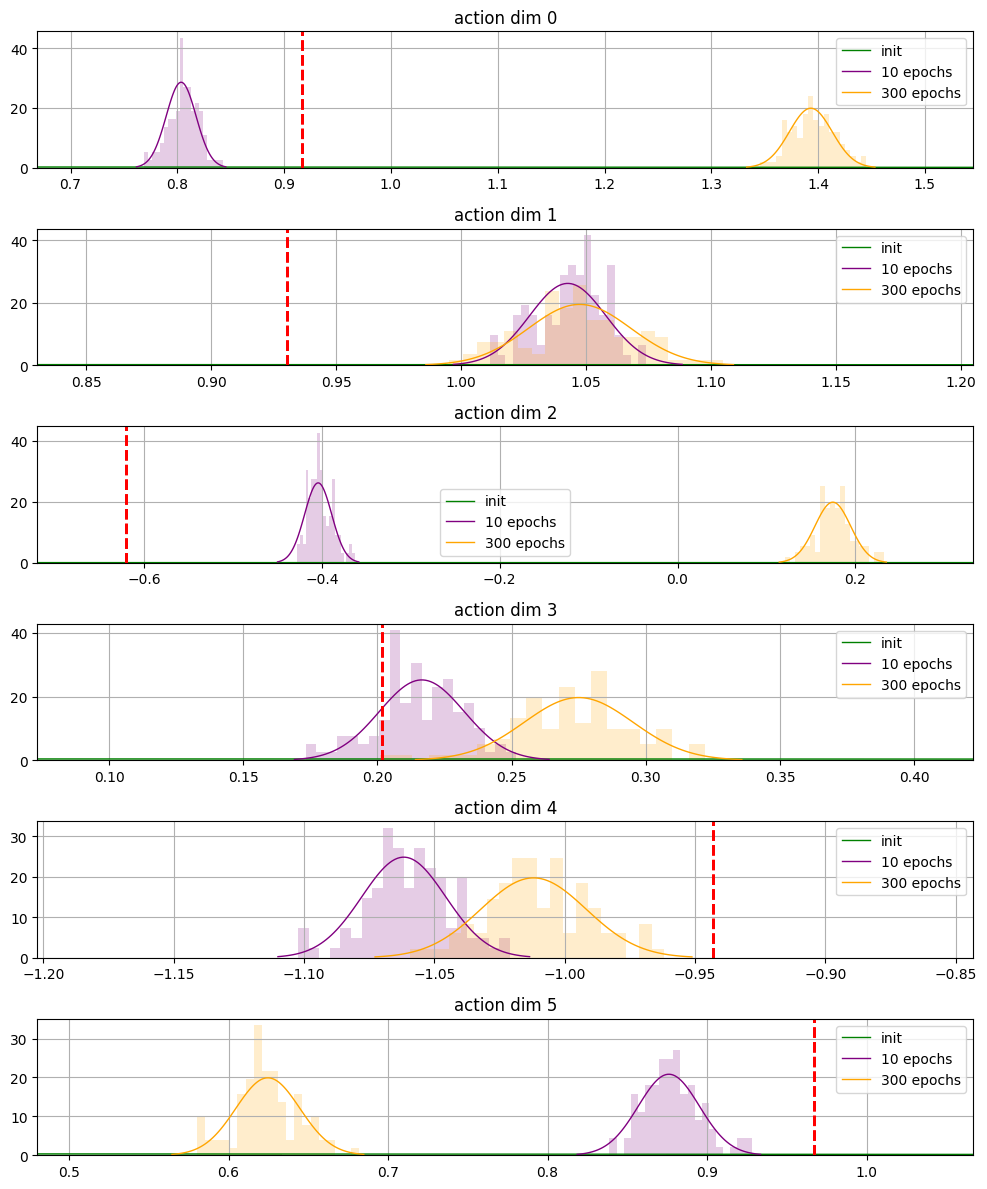

In [19]:
import matplotlib.pyplot as plt


num_generations = 100

poss = []
poss.append((False, None, "init"))
poss.append((True, "../models/mlp-policy/grpo_compatible/full_std_10ep", "10 epochs"))
poss.append((True, "../models/mlp-policy/grpo_compatible/full_std_300ep", "300 epochs"))

colors = ["green", "purple", "orange"]  # Add more colors if needed

one_ex = examples[15]
obs = one_ex["state"]
gt_action = one_ex["action"]
action_dim = len(gt_action)

# Create subplots for each action dimension
fig, axes = plt.subplots(action_dim, 1, figsize=(10, 2 * action_dim))

min_x, max_x = gt_action, gt_action
for idx, (lm, path, tag) in enumerate(poss):
    if not lm:
        model = create_mlp_model(
            obs_dim=input_dim, action_dim=output_dim, hidden_dims=[256, 256]
        )
    else:
        model = load_mlp_model(model_path=path)

    mean, std = model.forward(torch.tensor(obs))
    dist = torch.distributions.Normal(mean, std)
    gen_actions = dist.sample((num_generations,)).detach().cpu().numpy()

    if lm:
        min_x = np.minimum(min_x, gen_actions.min(axis=0))
        max_x = np.maximum(max_x, gen_actions.max(axis=0))

    # Plot distribution and ground truth for each action dimension
    for i in range(action_dim):
        # Extract generated actions for the current dimension
        generated_actions_i = [action[i] for action in gen_actions]

        # Plot histogram of generated actions
        color = colors[idx % len(colors)]  # Cycle through colors
        axes[i].hist(
            generated_actions_i,
            bins=20,
            alpha=0.2,
            density=True,
            stacked=True,
            color=color,
        )

        # Plot ground truth action as a vertical line
        axes[i].axvline(
            gt_action[i],
            color="red",
            linestyle="dashed",
            linewidth=2,  # label="Ground Truth"
        )

        # Plot Gaussian PDF
        x = np.linspace(
            mean[i].item() - 3 * std[i].item(), mean[i].item() + 3 * std[i].item(), 100
        )
        p = np.exp(-0.5 * ((x - mean[i].item()) / std[i].item()) ** 2) / (
            std[i].item() * np.sqrt(2 * np.pi)
        )
        axes[i].plot(x, p, "-", linewidth=1, label=tag, color=color)

        # Set labels and title
        # axes[i].set_xlabel("action")
        # axes[i].set_ylabel("Frequency")
        axes[i].set_title(f"action dim {i}")
        axes[i].legend()
        axes[i].grid(True)

for i in range(action_dim):
    axes[i].set_xlim(min_x[i] - 0.1, max_x[i] + 0.1)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

number of kept samples: 22075 (22.07%)


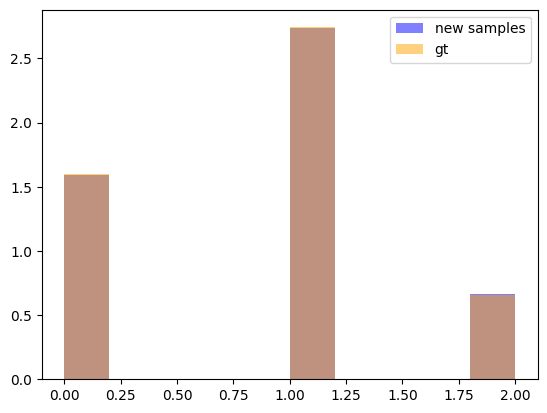

In [108]:
# prior distribution
p_pr = [0.1, 0.6, 0.3]
# initial distribution
p = [0.7, 0.2, 0.1]
# groudntruth p*p_pr
p_times_p_pr = [p[i] * p_pr[i] for i in range(len(p))]
p_times_p_pr = [x / sum(p_times_p_pr) for x in p_times_p_pr]

num_samples = 100000
# sample from p
samples = np.random.choice(a=[0, 1, 2], p=p, size=(num_samples,))

new_samples = []
for s in samples:
    # only keep samples with probabilities from p_pr (rejection sampling)
    if np.random.rand() < p_pr[s]:
        new_samples.append(s)

print(
    f"number of kept samples: {len(new_samples)} ({len(new_samples) / num_samples:.2%})"
)

plt.figure()
plt.hist(new_samples, density=True, alpha=0.5, label="new samples", color="blue")
plt.hist(
    np.random.choice(a=[0, 1, 2], p=p_times_p_pr, size=(len(new_samples),)),
    density=True,
    alpha=0.5,
    label="gt",
    color="orange",
)
plt.legend()
plt.show()